## This is the starter notebook for the challenge

#### starter libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Neural network architecture

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### We are going to use the Mnist dataset

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#### And there you go!

In [ ]:
def train_test_model(batch_size, learning_rate, epochs) :
  # Define data loaders
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

  # Initialize the model, loss function, and optimizer
  model = NN()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Training the model
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

  # Evaluate the model
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

# Genetic Algorithm

## Genetic Algorithm (GA)

A **Genetic Algorithm (GA)** is a heuristic search algorithm inspired by the process of natural selection. It is used to find approximate solutions to optimization and search problems by mimicking the process of evolution. GA operates by evolving a population of candidate solutions to a problem over several generations.

GA is a powerful optimization tool used for complex search problems where other traditional optimization methods may fail.


In [ ]:
nb_individuals = 3

## initial population creation

## Key Components of Genetic Algorithm


### 1. **Initial Population**
The initial population is a randomly generated set of potential solutions to the problem. Each solution is represented as a **chromosome** (a sequence of genes) that encodes a candidate solution. The size of the population can be defined by the user.

In [ ]:
def PI() :
  population = []
  batch_size = [i for i in range(1, 100)]
  learning_rate = [0.001, 0.01, 0.1]
  epochs = [i for i in range(1, 5)]
  #On crée une copie de la liste mélangée en utilisant clients[:]
  #et on l'ajoute à la liste matrice.
  #Ceci garantit que chaque sous-liste dans la matrice est une copie séparée de la liste clients mélangée.
  for _ in range(nb_individuals) :
    population.append([random.choice(batch_size), random.choice(learning_rate), random.choice(epochs)])
  return population


### 2. **Fitness Function (Score)**
The fitness function evaluates how good a solution is. Each individual in the population is assigned a fitness score based on its performance on the problem. The fitness score is used to guide the selection process, where individuals with higher fitness scores are more likely to be selected for reproduction.

In [ ]:
def fitness(solution):
  return train_test_model(solution[0], solution[1], solution[2])

In [ ]:
def solution_score(solution) :
  dict_solution_score = {}
  score = fitness(solution)
  dict_solution_score["solution"] = solution
  dict_solution_score["score_fitness"] = score
  return dict_solution_score

### 3. **Crossover (Recombination)**
Crossover is the process of combining the genetic information of two parent solutions to produce offspring. This mimics biological reproduction where two organisms combine their genetic material to create a new individual.

#### Types of Crossover:
- **Single-point crossover**: A single crossover point is selected, and the genetic material from two parents is exchanged after this point.
- **Two-point crossover**: Two crossover points are chosen, and the genetic material between them is exchanged.
- **Uniform crossover**: Genes from both parents are randomly selected to create the offspring.

In [ ]:
def croisement(parent1, parent2):
    # Define the crossover point
    point_croisement = 1

    # Create offspring initialized with parts of parents
    enfant1 = parent1[:point_croisement] + parent2[point_croisement:]
    enfant2 = parent2[:point_croisement] + parent1[point_croisement:]

    return enfant1, enfant2

### 4. **Generating New Generation**
After selection, crossover, and mutation, a new generation is created. The new generation replaces the old generation, and the process repeats for a specified number of generations. The individuals of the new generation are evaluated based on their fitness, and the process continues until the termination criteria are met.

In [ ]:
def creation_nouvelle_generation(population) :
  nouvelle_generation = []
  for _ in range(nb_individuals) :
      parent1, parent2 = random.sample(population, k= 2) # selection de deux parents aleatoirement
      enfant1, enfant2 = croisement(parent1, parent2) # appelle a la fonction croisement pour generer deux solutions enfants a partir des deux parents
      nouvelle_generation.extend([parent1, parent2, enfant1[:], enfant2[:]]) # ajouter a la nouvelle generation les deux enfants avec leurs parents
  return nouvelle_generation

### 5. **Selection**
Selection is the process of choosing individuals from the population to create offspring for the next generation. The selection process aims to give preference to individuals with higher fitness scores, but it can also allow some diversity by selecting weaker individuals occasionally.

#### Types of Selection Methods:
- **Roulette Wheel Selection**: Individuals are selected based on their fitness, with higher fitness individuals having a higher chance of being selected.
- **Tournament Selection**: A subset of individuals is randomly selected, and the best individual from this subset is chosen.

In [ ]:
def selectionGen(generation):
    meilleurs_solutions = sorted(generation, key=lambda x: x['score_fitness'], reverse= True)
    meilleurs_solutions = meilleurs_solutions[:nb_individuals]
    return meilleurs_solutions

### 6. **Mutation**
Mutation is a random change in the genetic material of an individual. It introduces diversity into the population by modifying some of the genes in an individual’s chromosome. Mutation is applied after crossover to ensure genetic variation.

#### Types of Mutation:
- **Bit-flip mutation**: A single bit in the chromosome is flipped (for binary encoding).
- **Swap mutation**: Two genes are swapped in the chromosome.
- **Gaussian mutation**: A gene value is modified by a small random number (for continuous values).

In [ ]:
def mutation(generation, taux_mutation):
    if random.random() > taux_mutation :
        return generation
    else :
        random_solution = random.choice(generation)
        random_solution["solution"] = PI()[0]
        random_solution["score_fitness"] = fitness(random_solution["solution"])
        return generation

## Key Parameters of Genetic Algorithm

### 1. **Number of Generations**
The number of generations represents how many iterations of evolution the algorithm will perform. The algorithm stops when it reaches the predefined number of generations, or when other stopping criteria (such as convergence) are met.

### 2. **Number of Individuals per Generation**
This is the size of the population at each generation. A larger population provides more genetic diversity but increases computational complexity. A smaller population may lead to faster convergence but risks premature convergence.

### 3. **Crossover Rate**
This parameter determines how often crossover will occur between two parent solutions. A higher crossover rate promotes greater exploration of the search space, while a lower crossover rate leads to slower exploration and more exploitation of existing solutions.

### 4. **Mutation Rate**
The mutation rate controls the probability that a mutation will occur for a given individual. A higher mutation rate introduces more randomness and increases genetic diversity, while a lower mutation rate makes the algorithm more deterministic and convergent.

### 5. **Elitism**
Elitism ensures that the best individual(s) from the current generation are passed directly to the next generation without modification. This ensures that the solution does not degrade due to stochastic processes.

In [ ]:
nb_iteration = 4 # le nombre d'iteration (critère d'arret)
population = PI() # creation de la population initiale

# creation de graphe (solution optimale - nombre de generation )
solutions_optimales = [] # liste qui contient les solutions optimales des differentes generations
taux_mutation = 0.4

for _ in tqdm(range(nb_iteration), total= nb_iteration, desc=f"Loading %"):
    if _ == 0 : # dans la premeire iteration on prend la population initiale pour develloper la nouvelle generation
        generation = creation_nouvelle_generation(population)
    else : # sinon on dèmarre par la la generation prècèdente
        generation = creation_nouvelle_generation(generation)

    for i, solution in enumerate(generation): # partie d'èvalluation
        generation[i] = solution_score(solution)

    generation = selectionGen(generation) # partie de Selection
    mutation(generation, taux_mutation)

    generation = [solution['solution'] for solution in generation] # prendre seulement le champ "solution" de chaque dictionnaire de generation avant la prochaine iteration

    solutions_optimales.append(generation[0]) # la meilleure solution de la generation actuelle

print(f"liste des solutions optimales : {solutions_optimales[-1]}")

Loading %: 100%|██████████| 4/4 [1:02:59<00:00, 944.80s/it]

liste des solutions optimales : [49, 0.001, 4]


In [ ]:
def grid_search(hyperparameter_grid):
    best_accuracy = 0
    best_params = None

    for params in hyperparameter_grid:
        batch_size, learning_rate, epochs = params
        print(f"Testing with batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")
        accuracy = train_test_model(batch_size, learning_rate, epochs)
        print(f"Accuracy: {accuracy:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    return best_params, best_accuracy

# Define the grid of hyperparameters
batch_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
epochs_list = [5, 10]

# Create all combinations of hyperparameters
from itertools import product
hyperparameter_grid = list(product(batch_sizes, learning_rates, epochs_list))

# Perform GridSearch
best_params, best_accuracy = grid_search(hyperparameter_grid)
print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.2f}%")

Testing with batch_size=32, learning_rate=0.01, epochs=5
Accuracy: 93.03%
Testing with batch_size=32, learning_rate=0.01, epochs=10
Accuracy: 92.62%
Testing with batch_size=32, learning_rate=0.001, epochs=5
Accuracy: 96.61%
Testing with batch_size=32, learning_rate=0.001, epochs=10
Accuracy: 97.21%
Testing with batch_size=32, learning_rate=0.0001, epochs=5
Accuracy: 94.50%
Testing with batch_size=32, learning_rate=0.0001, epochs=10
Accuracy: 96.25%
Testing with batch_size=64, learning_rate=0.01, epochs=5
Accuracy: 91.15%
Testing with batch_size=64, learning_rate=0.01, epochs=10
Accuracy: 93.15%
Testing with batch_size=64, learning_rate=0.001, epochs=5
Accuracy: 96.53%
Testing with batch_size=64, learning_rate=0.001, epochs=10
Accuracy: 97.17%
Testing with batch_size=64, learning_rate=0.0001, epochs=5
Accuracy: 93.45%
Testing with batch_size=64, learning_rate=0.0001, epochs=10
Accuracy: 95.51%
Testing with batch_size=128, learning_rate=0.01, epochs=5
Accuracy: 94.78%
Testing with batch_

In [ ]:
def randomized_search(hyperparameter_space, n_iter=10):
    best_accuracy = 0
    best_params = None

    for _ in range(n_iter):
        # Randomly sample hyperparameters
        batch_size = random.choice(hyperparameter_space["batch_size"])
        learning_rate = random.choice(hyperparameter_space["learning_rate"])
        epochs = random.choice(hyperparameter_space["epochs"])

        print(f"Testing with batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")
        accuracy = train_test_model(batch_size, learning_rate, epochs)
        print(f"Accuracy: {accuracy:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (batch_size, learning_rate, epochs)

    return best_params, best_accuracy


# Define the space of hyperparameters
hyperparameter_space = {
    "batch_size": [32, 64, 128],
    "learning_rate": [0.01, 0.001, 0.0001],
    "epochs": [5, 10],
}

# Perform RandomizedSearch
best_params, best_accuracy = randomized_search(hyperparameter_space, n_iter=10)
print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.2f}%")

Testing with batch_size=128, learning_rate=0.001, epochs=10
Accuracy: 97.18%
Testing with batch_size=32, learning_rate=0.001, epochs=10
Accuracy: 97.43%
Testing with batch_size=32, learning_rate=0.01, epochs=5
Accuracy: 91.26%
Testing with batch_size=128, learning_rate=0.001, epochs=10
Accuracy: 97.42%
Testing with batch_size=64, learning_rate=0.01, epochs=10
Accuracy: 92.94%
Testing with batch_size=64, learning_rate=0.001, epochs=10
Accuracy: 97.26%
Testing with batch_size=32, learning_rate=0.001, epochs=10
Accuracy: 97.17%
Testing with batch_size=128, learning_rate=0.01, epochs=5
Accuracy: 94.03%
Testing with batch_size=128, learning_rate=0.0001, epochs=5
Accuracy: 92.42%
Testing with batch_size=32, learning_rate=0.0001, epochs=10
Accuracy: 96.33%
Best parameters: (32, 0.001, 10)
Best accuracy: 97.43%


In [ ]:
a = train_test_model(49, 0.001, 4)
a

96.71

In [ ]:
# Example data for GridSearchCV, RandomizedSearchCV, and GA results
results = {
    'Method': ['Grid Search', 'Randomized Search', 'Genetic Algorithm'],
    'Best Hyperparameters': [
        'batch_size = 32 , lr = 0.001, epochs = 10',     # Example GridSearch result
        'batch_size = 32, lr = 0.001, epochs = 10',    # Example RandomizedSearch result
        'batch_size= 49, lr=0.001, epochs=4'],  # Example GA result
    'Best Score': [97.21, 97.43, 96.71],   # Example scores for each method
    'Time Taken (min)': [15, 29, 60],   # Example time taken for each method
}

# Create a pandas DataFrame
comparison_df = pd.DataFrame(results)

# Display the table
comparison_df

,Method,Best Hyperparameters,Best Score,Time Taken (min)
0,Grid Search,"batch_size = 32 , lr = 0.001, epochs = 10",97.21,15
1,Randomized Search,"batch_size = 32, lr = 0.001, epochs = 10",97.43,29
2,Genetic Algorithm,"batch_size= 49, lr=0.001, epochs=4",96.71,60


<ipython-input-42-82bb1bf01e96>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Time Taken (min)', data=comparison_df, palette='magma')


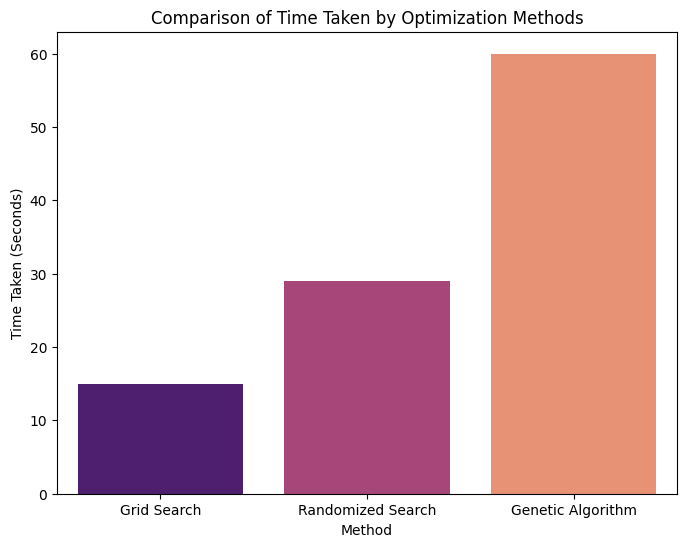

In [ ]:
# Plotting a bar chart to compare the time taken by each method
plt.figure(figsize=(8, 6))
sns.barplot(x='Method', y='Time Taken (min)', data=comparison_df, palette='magma')
plt.title('Comparison of Time Taken by Optimization Methods')
plt.ylabel('Time Taken (Seconds)')
plt.xlabel('Method')
plt.show()

# Hyperparameter Optimization: Grid Search vs Randomized Search vs Genetic Algorithm (GA)

## Results Summary

| Index | Method              | Hyperparameters                           | Best Score (%) | Time Taken (seconds) |
|-------|---------------------|-------------------------------------------|----------------|----------------------|
| 0     | **Grid Search**      | batch_size = 32, lr = 0.001, epochs = 10  | 97.21          | 15                   |
| 1     | **Randomized Search**| batch_size = 32, lr = 0.001, epochs = 10  | 97.43          | 29                   |
| 2     | **Genetic Algorithm**| batch_size = 49, lr = 0.001, epochs = 4   | 96.71          | 60                   |

## Analysis

### 1. **Grid Search**
   - **Best Score**: 97.21%
   - **Time Taken**: 15 minuts
   - **Advantages**:
     - Performs exhaustive search over a predefined set of hyperparameters.
     - Suitable for small, discrete search spaces.
     - Quick results when the hyperparameter space is limited.
   - **Limitations**:
     - Inefficient for large or continuous search spaces.
     - May miss better solutions in complex spaces.

### 2. **Randomized Search**
   - **Best Score**: 97.43%
   - **Time Taken**: 29 minuts
   - **Advantages**:
     - Randomly samples hyperparameter space, providing more flexibility.
     - Can be faster than Grid Search when the search space is large.
     - More efficient than Grid Search in some cases, as it may find good results faster.
   - **Limitations**:
     - May not find the absolute best solution if the sampling is not broad enough.
     - Still may not be efficient in very large search spaces.

### 3. **Genetic Algorithm (GA)**
   - **Best Score**: 96.71%
   - **Time Taken**: 60 minuts
   - **Advantages**:
     - Useful for complex, large, or non-linear search spaces.
     - Flexible and adaptable to different optimization problems.
     - Can incorporate domain-specific constraints or preferences.
   - **Limitations**:
     - Computationally expensive and slower to converge.
     - May not always provide better performance than traditional methods like Grid Search or Randomized Search.

## Final Interpretation

- **Grid Search**: Performs well with small, discrete search spaces. It is quick and efficient but may miss better results in larger spaces.
- **Randomized Search**: Slightly outperforms Grid Search in terms of accuracy while being more efficient in larger search spaces.
- **Genetic Algorithm**: Takes more time and results in slightly lower accuracy compared to Grid Search and Randomized Search. However, it is a strong candidate for large and complex search spaces.

## When to Use Genetic Algorithm (GA)
- **Large and Complex Search Spaces**: GA is suitable for problems with large, non-linear, or continuous hyperparameter spaces where traditional methods may struggle.
- **Difficult-to-Model Problems**: If the relationship between hyperparameters is not straightforward or well-defined, GA can adapt to find better solutions.
- **Flexibility**: GA is ideal when domain-specific constraints or preferences need to be incorporated.

## When to Use Grid Search or Randomized Search
- **Small and Discrete Search Spaces**: If the search space is small and discrete, Grid Search or Randomized Search will be much faster and efficient.
- **Quick Results**: When you need quick results and the search space is well-understood, Grid Search and Randomized Search are preferable.
- **Smooth Objective Functions**: If the objective function is smooth and continuous, Grid Search or Randomized Search will often be sufficient.

## Conclusion
- **Grid Search and Randomized Search** are more efficient for smaller, well-defined search spaces, and they provide fast results.
- **Genetic Algorithm (GA)** is better suited for more complex, large, or poorly understood search spaces, though it is computationally more expensive.